CONNECTING TO GOOGLE DRIVE TO FETCH DATA

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


IMPORTING LIBRARIES

In [2]:
import os
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
import tensorflow as tf
from tensorflow.keras import layers, Sequential, preprocessing
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
import PIL
from PIL import ImageOps
!pip install segmentation-models
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Segmentation Models: using `keras` framework.


'tf.keras'

LOADING DATA

In [3]:
files_path = "/content/drive/MyDrive/Colab Notebooks/dataset1"

In [4]:
train_label_dir=os.path.join(files_path+'/annotations_prepped_train')
train_image_dir=os.path.join(files_path+'/images_prepped_train')
test_label_dir=os.path.join(files_path+'/annotations_prepped_test')
test_image_dir=os.path.join(files_path+'/images_prepped_test')
#Total Number
print('Total Training Images: ',len(os.listdir(train_image_dir)))
print('Total Training Ground Truth: ',len(os.listdir(train_label_dir)))
print('Total Test Images: ',len(os.listdir(test_image_dir)))
print('Total Ground Truth: ',len(os.listdir(test_label_dir)))
train_image = [os.path.join(train_image_dir,fname) for fname in os.listdir(train_image_dir)[:]]
train_label = [os.path.join(train_label_dir,fname) for fname in os.listdir(train_label_dir)[:]]
test_image = [os.path.join(test_image_dir,fname) for fname in os.listdir(test_image_dir)[:]]
test_label = [os.path.join(test_label_dir,fname) for fname in os.listdir(test_label_dir)[:]]
train_image.sort()
train_label.sort()
test_image.sort()
test_label.sort()


Total Training Images:  367
Total Training Ground Truth:  367
Total Test Images:  101
Total Ground Truth:  101


**Normalize image pixels**


In [6]:

from PIL import Image
image_size = (224,224)

#function to load data
def open_image(img):
    return np.array(Image.open(img).resize(image_size, Image.NEAREST))

train_images = np.stack([open_image(i) for i in train_image])
train_labels = np.stack([open_image(i) for i in train_label])
test_images = np.stack([open_image(i) for i in test_image])
test_labels = np.stack([open_image(i) for i in test_label])

print('Train Images Shape: ',train_images.shape)
print('Train labels Shape: ',train_labels.shape)
print('Test Images Shape: ',test_images.shape)
print('Test labels Shape: ',test_labels.shape)

Train Images Shape:  (367, 224, 224, 3)
Train labels Shape:  (367, 224, 224)
Test Images Shape:  (101, 224, 224, 3)
Test labels Shape:  (101, 224, 224)


Train - Val Split

In [7]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.2, random_state = 0)
print(X_train.shape)
print(X_val.shape)
y_train=np.expand_dims(y_train, -1)
print(y_train.shape)
y_val=np.expand_dims(y_val, -1)
print(y_val.shape)

(293, 224, 224, 3)
(74, 224, 224, 3)
(293, 224, 224, 1)
(74, 224, 224, 1)


Data Visualization

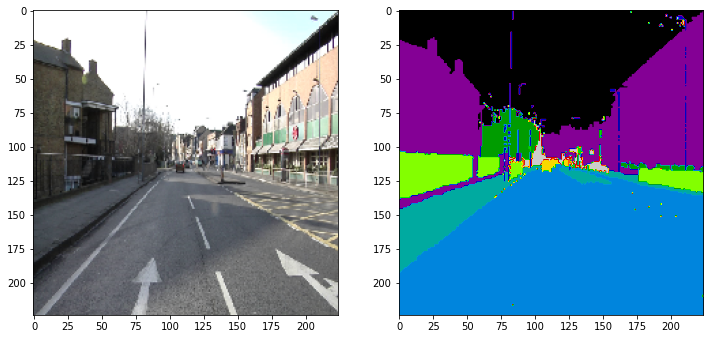

In [ ]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(10, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number], cmap='gray')
plt.subplot(122)
plt.imshow(tf.squeeze(y_train[image_number]), cmap='nipy_spectral')
plt.show()

Data Generator And Augmentation

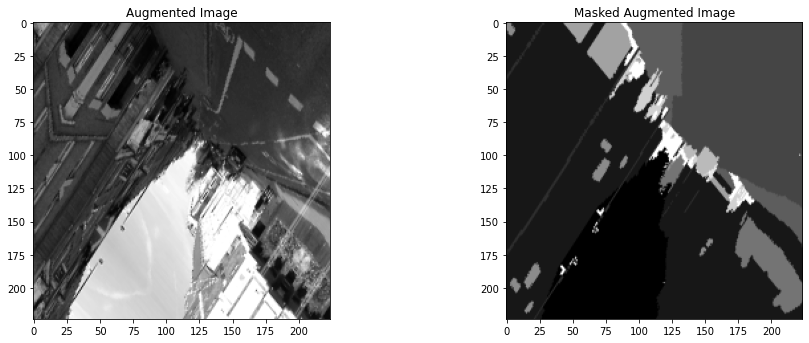

In [8]:

seed=24
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

labels_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect') 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_val, seed=seed)

mask_data_generator = ImageDataGenerator(**labels_data_gen_args)
mask_data_generator.fit(y_train+(1,), augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_val+(1,), seed=seed)

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)


x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    
    plt.figure(figsize=(24, 12))
    plt.subplot(231)
    plt.title('Augmented Image')
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(232)
    plt.title('Masked Augmented Image')
    plt.imshow(mask[:,:,0], cmap='gray')
    plt.show()

    

U_net with resnet34 for Sementic Segmentation

In [9]:
keras.backend.set_image_data_format('channels_last')
model = sm.Unet('vgg16', encoder_weights='imagenet')
model = sm.Unet('vgg16', classes=12, activation='sigmoid')
model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_2[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                           

Traning

In [ ]:
from segmentation_models.metrics import iou_score

model.compile(optimizer="Adam", loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score, 'Accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/dataset1/City_segmentation3.h5", save_best_only=True)
]

batch_size = 32
steps_per_epoch = 3*(len(X_train))//batch_size


epochs = 15
history=model.fit(my_generator, epochs=epochs, validation_data=validation_datagen,steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, callbacks=callbacks)

Epoch 1/15
27/27 [==============================] - 52s 1s/step - loss: -2.7398 - iou_score: 1.4463 - Accuracy: 0.1396 - val_loss: -3.5884 - val_iou_score: 1.3733 - val_Accuracy: 0.3853
Epoch 2/15
27/27 [==============================] - 32s 1s/step - loss: -10.8257 - iou_score: 2.2113 - Accuracy: 0.0595 - val_loss: -22.3800 - val_iou_score: 1.9719 - val_Accuracy: 0.1241
Epoch 3/15
27/27 [==============================] - 32s 1s/step - loss: -20.0252 - iou_score: 2.4568 - Accuracy: 0.1177 - val_loss: -26.6572 - val_iou_score: 2.2207 - val_Accuracy: 0.1777
Epoch 4/15
27/27 [==============================] - 31s 1s/step - loss: -30.8060 - iou_score: 2.5973 - Accuracy: 0.2446 - val_loss: -26.8763 - val_iou_score: 1.6250 - val_Accuracy: 0.1843
Epoch 5/15
27/27 [==============================] - 31s 1s/step - loss: -42.4258 - iou_score: 2.6384 - Accuracy: 0.3151 - val_loss: -76.2336 - val_iou_score: 3.0628 - val_Accuracy: 0.4355
Epoch 6/15
27/27 [==============================] - 32s 1s/ste

In [ ]:
from segmentation_models.metrics import iou_score

# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="Adam", loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score, 'Accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/dataset1/City_segmentation3.h5", save_best_only=True)
]

batch_size = 32
steps_per_epoch = 3*(len(X_train))//batch_size


# Train the model, doing validation at the end of each epoch.
epochs = 90
history=model.fit(my_generator, epochs=epochs, validation_data=validation_datagen,steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, callbacks=callbacks)

Epoch 1/90
27/27 [==============================] - 57s 2s/step - loss: -310.3833 - iou_score: 3.0453 - Accuracy: 0.5362 - val_loss: -367.4047 - val_iou_score: 3.5572 - val_Accuracy: 0.5935
Epoch 2/90
27/27 [==============================] - 31s 1s/step - loss: -337.5560 - iou_score: 3.0765 - Accuracy: 0.5455 - val_loss: -388.2434 - val_iou_score: 3.2758 - val_Accuracy: 0.5674
Epoch 3/90
27/27 [==============================] - 31s 1s/step - loss: -362.3351 - iou_score: 3.0733 - Accuracy: 0.5623 - val_loss: -439.8472 - val_iou_score: 3.3175 - val_Accuracy: 0.6102
Epoch 4/90
27/27 [==============================] - 31s 1s/step - loss: -392.5823 - iou_score: 3.0779 - Accuracy: 0.5806 - val_loss: -451.2670 - val_iou_score: 3.4071 - val_Accuracy: 0.6180
Epoch 5/90
27/27 [==============================] - 31s 1s/step - loss: -419.8094 - iou_score: 3.0886 - Accuracy: 0.5920 - val_loss: -514.6730 - val_iou_score: 3.5505 - val_Accuracy: 0.6799
Epoch 6/90
27/27 [==============================] 

In [ ]:
from segmentation_models.metrics import iou_score


model.compile(optimizer="Adam", loss=sm.losses.bce_jaccard_loss, metrics=[tf.keras.metrics.KLDivergence(name="kullback_leibler_divergence", dtype=None),tf.keras.metrics.Poisson(name="poisson", dtype=None), 'Accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/dataset1/City_segmentation3.h5", save_best_only=True)
]

batch_size = 32
steps_per_epoch = (4)*(len(X_train))//batch_size



epochs = 25
history=model.fit(my_generator, epochs=epochs, validation_data=validation_datagen,steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, callbacks=callbacks)

Epoch 1/25
36/36 [==============================] - 42s 1s/step - loss: -9121.7363 - kullback_leibler_divergence: 0.3177 - poisson: 0.9008 - Accuracy: 0.7023 - val_loss: -12312.1123 - val_kullback_leibler_divergence: 7.6601 - val_poisson: 1.5970 - val_Accuracy: 0.7272
Epoch 2/25
36/36 [==============================] - 37s 1s/step - loss: -9239.0625 - kullback_leibler_divergence: 0.3181 - poisson: 0.8968 - Accuracy: 0.6997 - val_loss: -10812.3242 - val_kullback_leibler_divergence: 9.2633 - val_poisson: 1.7583 - val_Accuracy: 0.6914
Epoch 3/25
36/36 [==============================] - 36s 1s/step - loss: -9514.3232 - kullback_leibler_divergence: 0.3371 - poisson: 0.8994 - Accuracy: 0.7036 - val_loss: -12085.6826 - val_kullback_leibler_divergence: 10.8467 - val_poisson: 2.0271 - val_Accuracy: 0.7205
Epoch 4/25
36/36 [==============================] - 37s 1s/step - loss: -9543.3887 - kullback_leibler_divergence: 0.4785 - poisson: 0.9643 - Accuracy: 0.7037 - val_loss: -12174.2578 - val_kull

Model Analysis

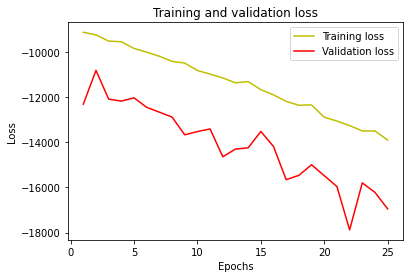

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import random

3/3 [==============================] - 0s 197ms/step
IoU socre is:  0.9516370217308502
3/3 [==============================] - 0s 169ms/step


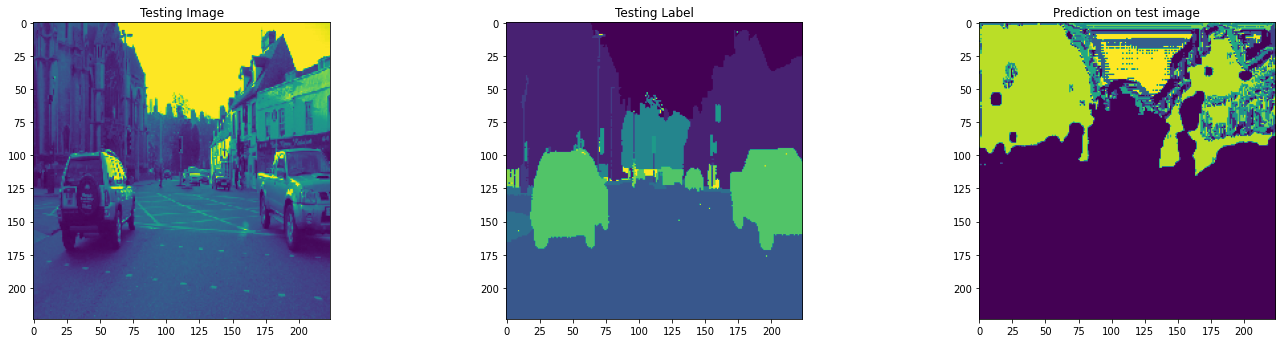

In [ ]:

#IOU
y_pred=model.predict(X_val)
y_pred_thresholded = y_pred > 0.5


intersection = np.logical_and(y_val, y_pred_thresholded)
union = np.logical_or(y_val, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

test_img_number = random.randint(0, len(X_val))
test_img = X_val[1]
ground_truth=y_val[1]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(X_val))

mask = np.argmax(prediction[1], axis=-1)
mask = np.expand_dims(mask, axis=-1)
img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))



plt.figure(figsize=(24, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(img)

plt.show()

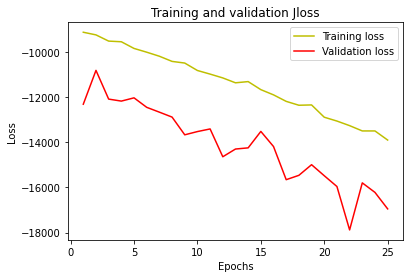

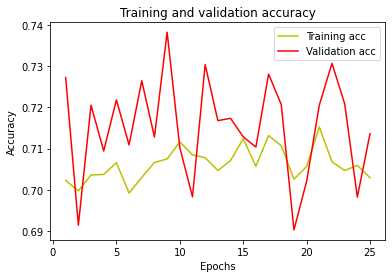

3/3 [==============================] - 0s 207ms/step
IoU socre is:  0.9516370217308502
3/3 [==============================] - 0s 169ms/step


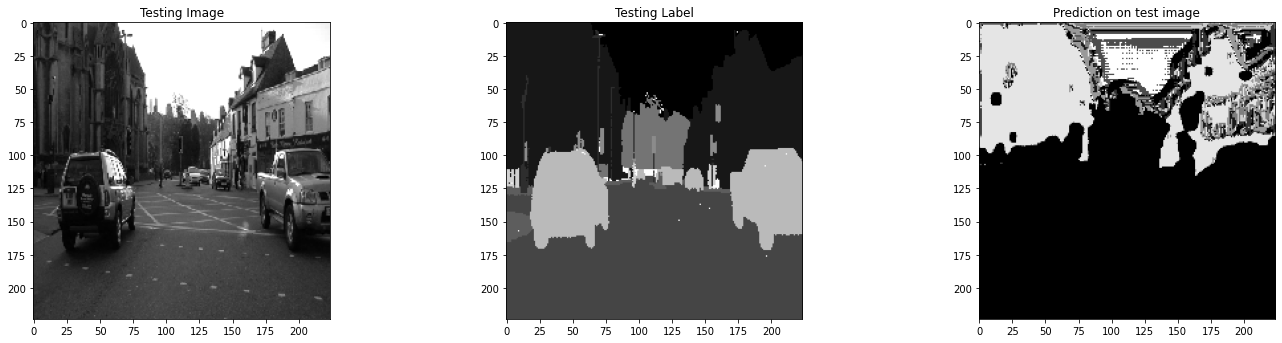

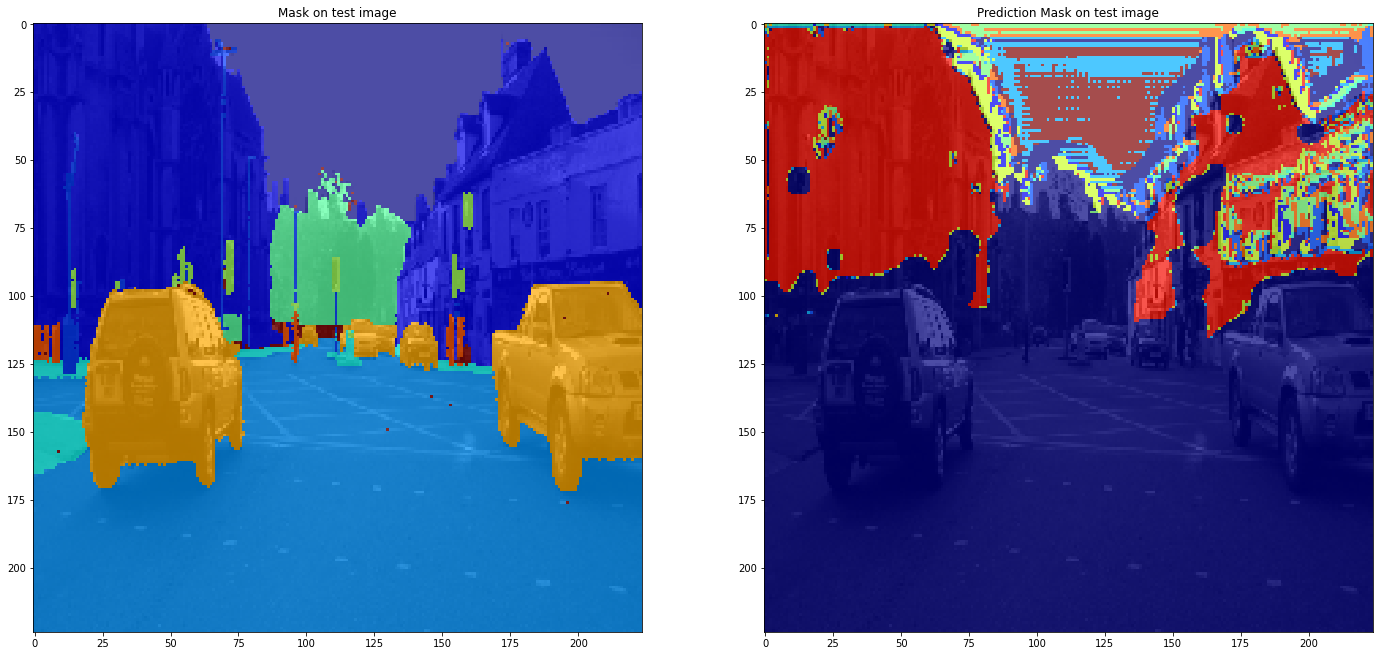

In [ ]:

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation Jloss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#IOU
y_pred=model.predict(X_val)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_val, y_pred_thresholded)
union = np.logical_or(y_val, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)


test_img_number = random.randint(0, len(X_val))
test_img = X_val[1]
ground_truth=y_val[1]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(X_val))

mask = np.argmax(prediction[1], axis=-1)
mask = np.expand_dims(mask, axis=-1)
img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))



plt.figure(figsize=(24, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(img, cmap='gray')

plt.show()
plt.figure(figsize=(24, 12))
plt.subplot(1,2,1)
plt.imshow(test_img[:,:,0], 'gray', interpolation='none')
plt.imshow(ground_truth[:,:,0], 'jet', interpolation='none', alpha=0.7)
plt.title('Mask on test image')
plt.subplot(1,2,2)
plt.imshow(test_img[:,:,0], 'gray', interpolation='none')
plt.imshow(img, 'jet', interpolation='none', alpha=0.7)
plt.title('Prediction Mask on test image')
plt.show()

KLdiv & possium

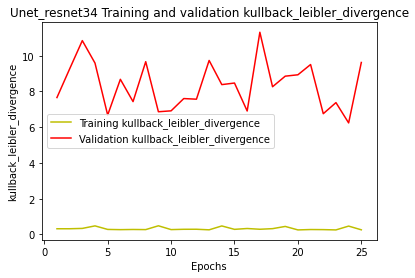

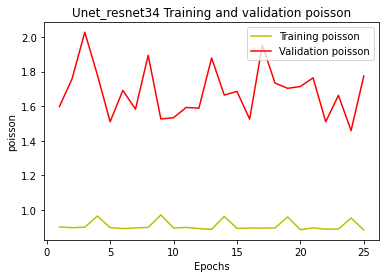

3/3 [==============================] - 0s 210ms/step
IoU socre is:  0.9504141659507366
3/3 [==============================] - 0s 170ms/step


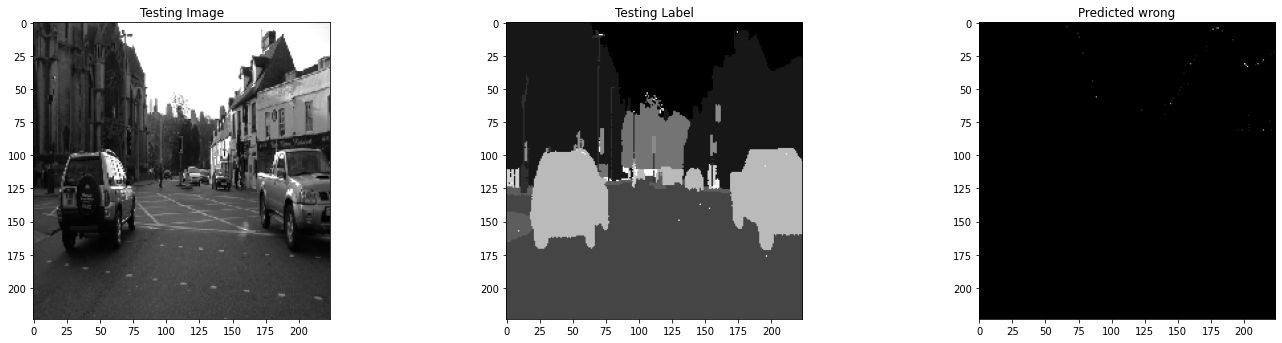

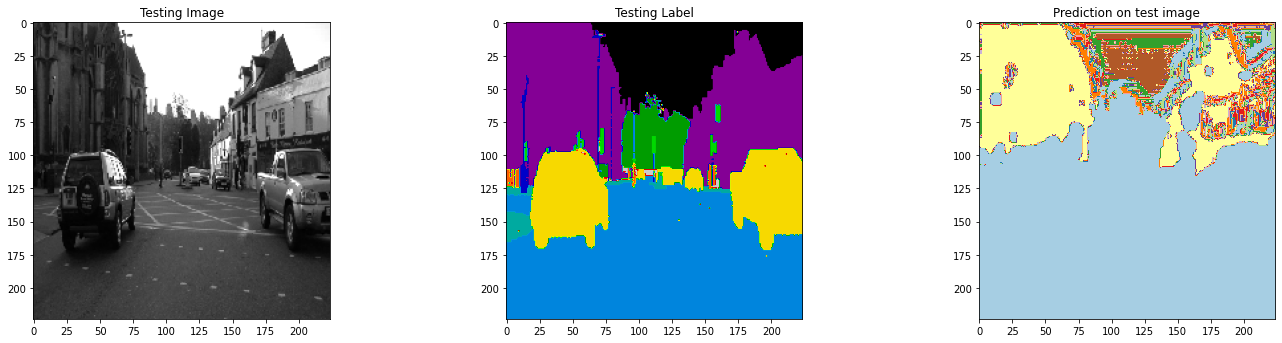

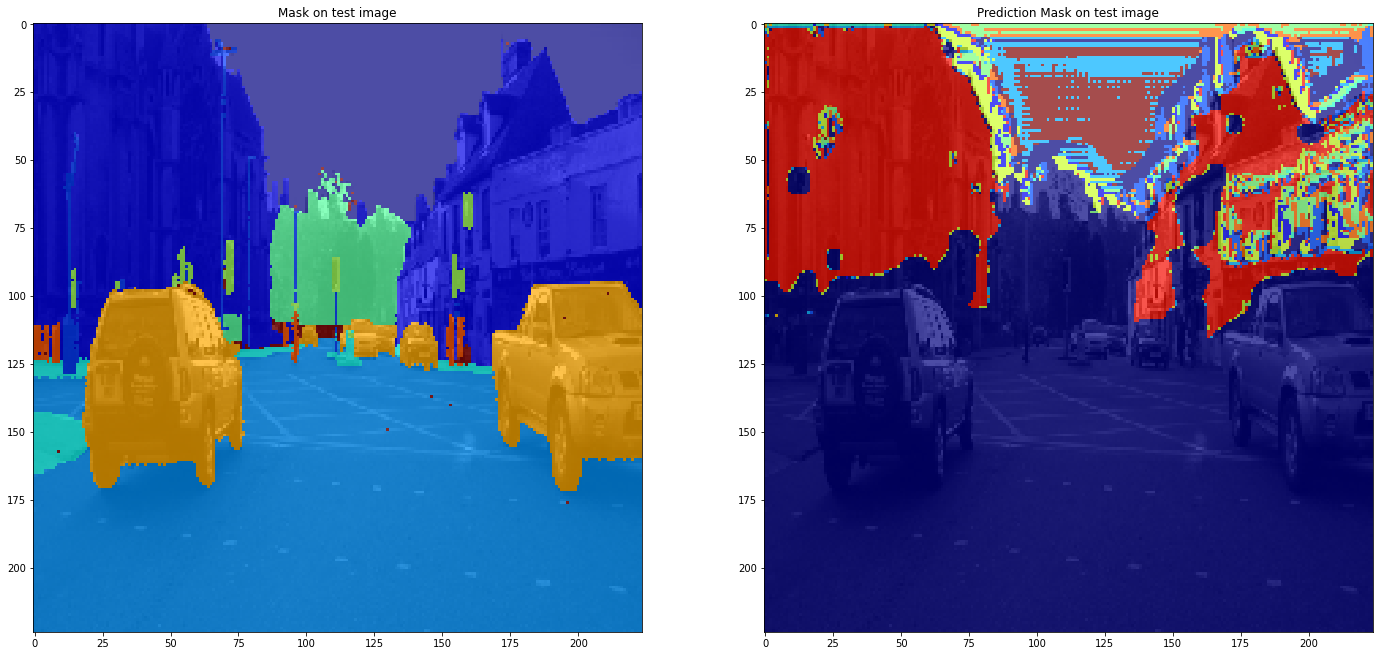

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['kullback_leibler_divergence']
val_loss = history.history['val_kullback_leibler_divergence']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training kullback_leibler_divergence')
plt.plot(epochs, val_loss, 'r', label='Validation kullback_leibler_divergence')
plt.title('Unet_resnet34 Training and validation kullback_leibler_divergence')
plt.xlabel('Epochs')
plt.ylabel('kullback_leibler_divergence')
plt.legend()
plt.show()

acc = history.history['poisson']
val_acc = history.history['val_poisson']

plt.plot(epochs, acc, 'y', label='Training poisson')
plt.plot(epochs, val_acc, 'r', label='Validation poisson')
plt.title('Unet_resnet34 Training and validation poisson')
plt.xlabel('Epochs')
plt.ylabel('poisson')
plt.legend()
plt.show()


#IOU
y_pred=model.predict(X_val)
y_pred_thresholded = y_pred > 0.9
y_pred_thresholdedL = y_pred < 0.45

test_img = X_val[1]
ground_truth=y_val[1]
wrongly= y_pred_thresholdedL[1]
mask = np.argmax(wrongly, axis=-1)
mask = np.expand_dims(mask, axis=-1)
imgw = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))

plt.figure(figsize=(24, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Predicted wrong')
plt.imshow(imgw, cmap='gray')



intersection = np.logical_and(y_val, y_pred_thresholded)
union = np.logical_or(y_val, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

test_img = X_val[1]
ground_truth=y_val[1]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(X_val))

mask = np.argmax(prediction[1], axis=-1)
mask = np.expand_dims(mask, axis=-1)
img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))



plt.figure(figsize=(24, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='nipy_spectral')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(img, cmap='Paired')

plt.show()
plt.figure(figsize=(24, 12))
plt.subplot(1,2,1)
plt.imshow(test_img[:,:,0], 'gray', interpolation='none')
plt.imshow(ground_truth[:,:,0], 'jet', interpolation='none', alpha=0.7)
plt.title('Mask on test image')
plt.subplot(1,2,2)
plt.imshow(test_img[:,:,0], 'gray', interpolation='none')
plt.imshow(img, 'jet', interpolation='none', alpha=0.7)
plt.title('Prediction Mask on test image')
plt.show()

Unet with MobileNet V2 For Sementic segmentation

In [10]:
BACKBONE = 'mobilenetv2'
preprocess_input = sm.get_preprocessing(BACKBONE)
keras.backend.set_image_data_format('channels_last')
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=12, activation='sigmoid')
model.summary()

/usr/local/lib/python3.7/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9406464/9406464 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['Conv1_pad[0][0]']              
                             

Traning

In [ ]:
from segmentation_models.metrics import iou_score


model.compile(optimizer="Adam", loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score, 'Accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/dataset1/City_segmentation4.h5", save_best_only=True)
]

batch_size = 32
steps_per_epoch = (4)*(len(X_train))//batch_size


epochs = 40
history=model.fit(my_generator, epochs=epochs, validation_data=validation_datagen,steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, callbacks=callbacks)

Epoch 1/40
36/36 [==============================] - 41s 998ms/step - loss: -3417.2700 - iou_score: 3.4228 - Accuracy: 0.6694 - val_loss: -6021.3994 - val_iou_score: 3.9986 - val_Accuracy: 0.8733
Epoch 2/40
36/36 [==============================] - 34s 968ms/step - loss: -3520.3408 - iou_score: 3.3791 - Accuracy: 0.6797 - val_loss: -6851.0303 - val_iou_score: 4.0467 - val_Accuracy: 0.8688
Epoch 3/40
36/36 [==============================] - 32s 923ms/step - loss: -3624.7646 - iou_score: 3.3774 - Accuracy: 0.6734 - val_loss: -6197.0454 - val_iou_score: 3.9136 - val_Accuracy: 0.8709
Epoch 4/40
36/36 [==============================] - 32s 898ms/step - loss: -3684.2622 - iou_score: 3.3673 - Accuracy: 0.6730 - val_loss: -5069.3711 - val_iou_score: 3.8548 - val_Accuracy: 0.8532
Epoch 5/40
36/36 [==============================] - 33s 918ms/step - loss: -3804.5789 - iou_score: 3.3758 - Accuracy: 0.6679 - val_loss: -6806.0815 - val_iou_score: 3.9297 - val_Accuracy: 0.8694
Epoch 6/40
36/36 [=======

In [ ]:
from segmentation_models.metrics import iou_score


model.compile(optimizer="Adam", loss=sm.losses.bce_jaccard_loss, metrics=[tf.keras.metrics.KLDivergence(name="kullback_leibler_divergence", dtype=None),tf.keras.metrics.Poisson(name="poisson", dtype=None), 'Accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/dataset1/City_segmentation44.h5", save_best_only=True)
]

batch_size = 32
steps_per_epoch = (4)*(len(X_train))//batch_size



epochs = 10
history=model.fit(my_generator, epochs=epochs, validation_data=validation_datagen,steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, callbacks=callbacks)

Epoch 1/10
36/36 [==============================] - 40s 969ms/step - loss: -9507.3457 - kullback_leibler_divergence: 0.2230 - poisson: 0.8773 - Accuracy: 0.6700 - val_loss: -16094.4922 - val_kullback_leibler_divergence: 1.7779 - val_poisson: 1.1191 - val_Accuracy: 0.8634
Epoch 2/10
36/36 [==============================] - 35s 977ms/step - loss: -9542.5625 - kullback_leibler_divergence: 0.4232 - poisson: 0.9556 - Accuracy: 0.6747 - val_loss: -16123.0312 - val_kullback_leibler_divergence: 1.6101 - val_poisson: 1.0999 - val_Accuracy: 0.8740
Epoch 3/10
36/36 [==============================] - 33s 925ms/step - loss: -9742.7939 - kullback_leibler_divergence: 0.4038 - poisson: 0.9523 - Accuracy: 0.6735 - val_loss: -15154.5029 - val_kullback_leibler_divergence: 1.1155 - val_poisson: 1.0607 - val_Accuracy: 0.8779
Epoch 4/10
36/36 [==============================] - 33s 919ms/step - loss: -9959.0635 - kullback_leibler_divergence: 0.4320 - poisson: 0.9554 - Accuracy: 0.6729 - val_loss: -15915.2695

Model Parameter Analysis

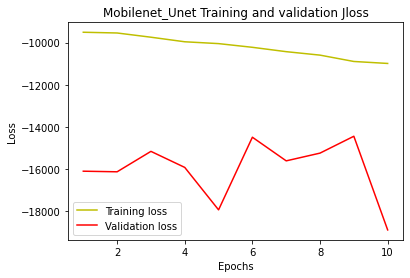

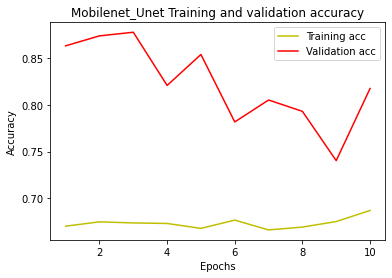

3/3 [==============================] - 0s 117ms/step
IoU socre is:  0.9336656440145967
3/3 [==============================] - 0s 87ms/step


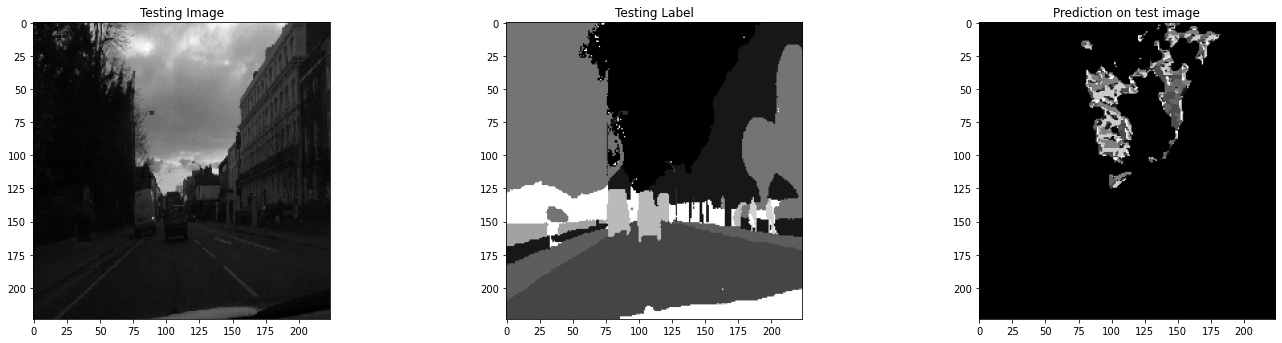

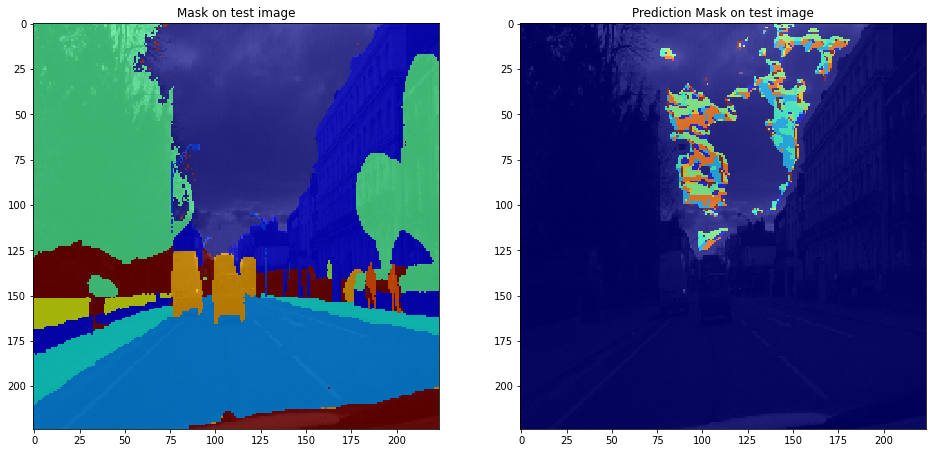

In [ ]:

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Mobilenet_Unet Training and validation Jloss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Mobilenet_Unet Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#IOU
y_pred=model.predict(X_val)
y_pred_thresholded = y_pred > 0.5


intersection = np.logical_and(y_val, y_pred_thresholded)
union = np.logical_or(y_val, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)


test_img = X_val[3]
ground_truth=y_val[3]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(X_val))

mask = np.argmax(prediction[3], axis=-1)
mask = np.expand_dims(mask, axis=-1)
img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))



plt.figure(figsize=(24, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(img, cmap='gray')

plt.show()
plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.imshow(test_img[:,:,0], 'gray', interpolation='none')
plt.imshow(ground_truth[:,:,0], 'jet', interpolation='none', alpha=0.7)
plt.title('Mask on test image')
plt.subplot(1,2,2)
plt.imshow(test_img[:,:,0], 'gray', interpolation='none')
plt.imshow(img, 'jet', interpolation='none', alpha=0.7)
plt.title('Prediction Mask on test image')
plt.show()

3/3 [==============================] - 0s 126ms/step
IoU socre is:  0.9188135526466497
3/3 [==============================] - 0s 89ms/step


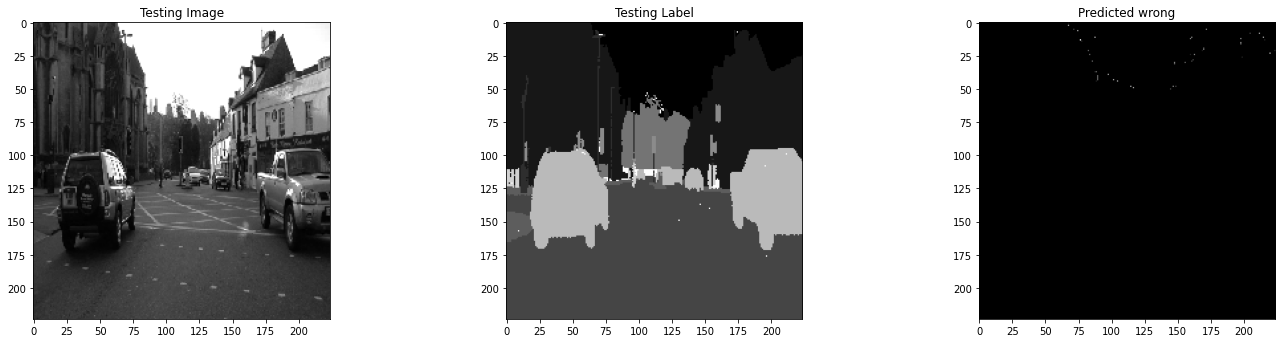

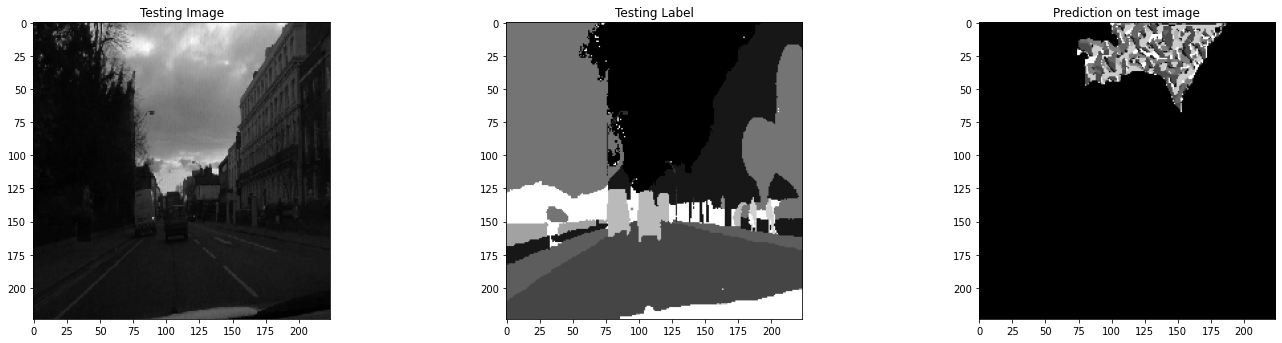

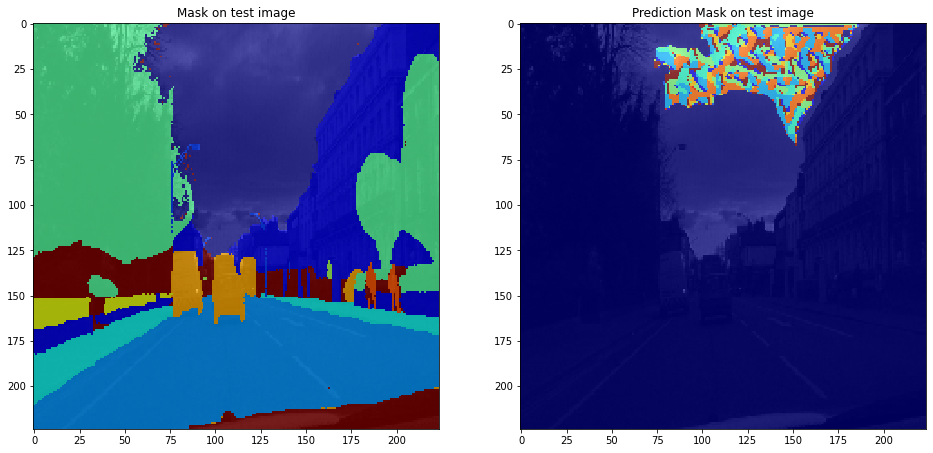

In [ ]:
#plot the training and validation accuracy and loss at each epoch

#IOU
y_pred=model.predict(X_val)
y_pred_thresholded = y_pred > 0.9
y_pred_thresholdedL = y_pred < 0.45

test_img = X_val[1]
ground_truth=y_val[1]
wrongly= y_pred_thresholdedL[1]
mask = np.argmax(wrongly, axis=-1)
mask = np.expand_dims(mask, axis=-1)
imgw = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))

plt.figure(figsize=(24, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Predicted wrong')
plt.imshow(imgw, cmap='gray')



intersection = np.logical_and(y_val, y_pred_thresholded)
union = np.logical_or(y_val, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)


test_img = X_val[3]
ground_truth=y_val[3]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(X_val))

mask = np.argmax(prediction[3], axis=-1)
mask = np.expand_dims(mask, axis=-1)
img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))



plt.figure(figsize=(24, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(img, cmap='gray')

plt.show()
plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.imshow(test_img[:,:,0], 'gray', interpolation='none')
plt.imshow(ground_truth[:,:,0], 'jet', interpolation='none', alpha=0.7)
plt.title('Mask on test image')
plt.subplot(1,2,2)
plt.imshow(test_img[:,:,0], 'gray', interpolation='none')
plt.imshow(img, 'jet', interpolation='none', alpha=0.7)
plt.title('Prediction Mask on test image')
plt.show()

LinkNet with MobileNet v2 for Sementic segmentation

In [12]:
BACKBONE = 'mobilenetv2'
preprocess_input = sm.get_preprocessing(BACKBONE)
keras.backend.set_image_data_format('channels_last')
# define model
model = sm.Linknet(BACKBONE, input_shape=(224, 224, 3), encoder_weights='imagenet', classes=12, activation='sigmoid')
model.summary()
#plot_model(model, to_file='/content/drive/MyDrive/Colab Notebooks/dataset1/Linknet_mobilenet_segmentation.png')

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1_pad (ZeroPadding2D)      (None, 225, 225, 3)  0           ['input_5[0][0]']                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['Conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

Model Traning

In [ ]:
from segmentation_models.metrics import iou_score

model.compile(optimizer="Adam", loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score,tf.keras.metrics.KLDivergence(name="kullback_leibler_divergence", dtype=None),tf.keras.metrics.Poisson(name="poisson", dtype=None), 'Accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/dataset1/City_segmentation42221.h5", save_best_only=True)
]

batch_size = 32
steps_per_epoch = (4)*(len(X_train))//batch_size


# Train the model, doing validation at the end of each epoch.
epochs = 40
history=model.fit(my_generator, epochs=epochs, validation_data=validation_datagen,steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, callbacks=callbacks)

Epoch 1/40
36/36 [==============================] - 55s 1s/step - loss: -3.6936 - iou_score: 1.4948 - kullback_leibler_divergence: 4.0770 - poisson: 1.8454 - Accuracy: 0.0212 - val_loss: -56.3115 - val_iou_score: 3.5694 - val_kullback_leibler_divergence: 6.0881 - val_poisson: 3.1284 - val_Accuracy: 0.0024
Epoch 2/40
36/36 [==============================] - 34s 973ms/step - loss: -17.8161 - iou_score: 2.3575 - kullback_leibler_divergence: 2.2033 - poisson: 1.2236 - Accuracy: 0.2631 - val_loss: -302.1644 - val_iou_score: 3.0795 - val_kullback_leibler_divergence: 0.9869 - val_poisson: 1.3010 - val_Accuracy: 0.3211
Epoch 3/40
36/36 [==============================] - 35s 977ms/step - loss: -35.6506 - iou_score: 2.3605 - kullback_leibler_divergence: 2.1932 - poisson: 1.2307 - Accuracy: 0.2521 - val_loss: -343.5825 - val_iou_score: 2.8843 - val_kullback_leibler_divergence: 1.5498 - val_poisson: 1.3949 - val_Accuracy: 0.7173
Epoch 4/40
36/36 [==============================] - 33s 951ms/step - 

In [ ]:
from segmentation_models.metrics import iou_score

model.compile(optimizer="Adam", loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score,tf.keras.metrics.KLDivergence(name="kullback_leibler_divergence", dtype=None),tf.keras.metrics.Poisson(name="poisson", dtype=None), 'Accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/dataset1/City_segmentation42221.h5", save_best_only=True)
]

batch_size = 32
steps_per_epoch = (4)*(len(X_train))//batch_size


# Train the model, doing validation at the end of each epoch.
epochs = 90
history=model.fit(my_generator, epochs=epochs, validation_data=validation_datagen,steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, callbacks=callbacks)

Epoch 1/90
36/36 [==============================] - 41s 1s/step - loss: -3401.3003 - iou_score: 3.0514 - kullback_leibler_divergence: 0.4620 - poisson: 0.9853 - Accuracy: 0.6499 - val_loss: -8386.3779 - val_iou_score: 3.9952 - val_kullback_leibler_divergence: 0.4049 - val_poisson: 1.0278 - val_Accuracy: 0.8284
Epoch 2/90
36/36 [==============================] - 33s 919ms/step - loss: -3427.3989 - iou_score: 2.9753 - kullback_leibler_divergence: 0.4594 - poisson: 0.9890 - Accuracy: 0.6431 - val_loss: -6556.7495 - val_iou_score: 4.0253 - val_kullback_leibler_divergence: 0.3587 - val_poisson: 1.0184 - val_Accuracy: 0.8425
Epoch 3/90
36/36 [==============================] - 33s 926ms/step - loss: -3541.7727 - iou_score: 3.0228 - kullback_leibler_divergence: 0.4368 - poisson: 0.9904 - Accuracy: 0.6547 - val_loss: -7567.4937 - val_iou_score: 4.0349 - val_kullback_leibler_divergence: 0.3063 - val_poisson: 1.0196 - val_Accuracy: 0.8592
Epoch 4/90
36/36 [==============================] - 34s 96

Model Analysis

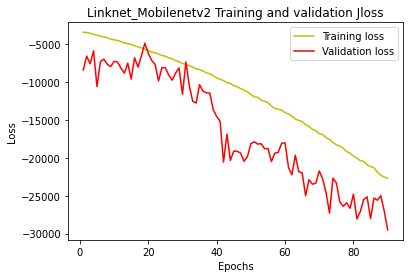

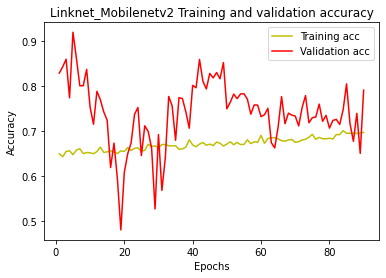

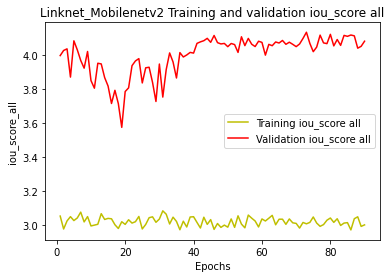

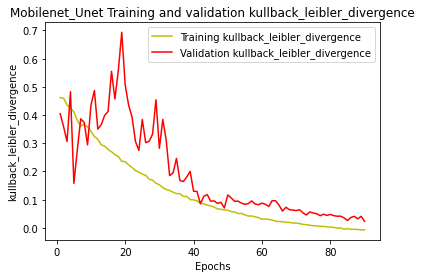

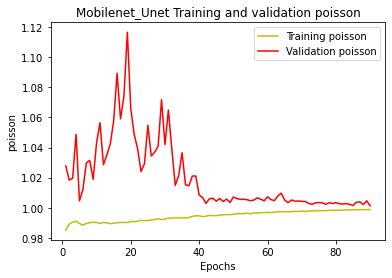

3/3 [==============================] - 0s 106ms/step
validation accuracy (224, 224, 11)
IoU socre is:  0.8400417018581081
3/3 [==============================] - 0s 78ms/step
(224, 224)
(224, 224, 1)
(224, 224, 1)


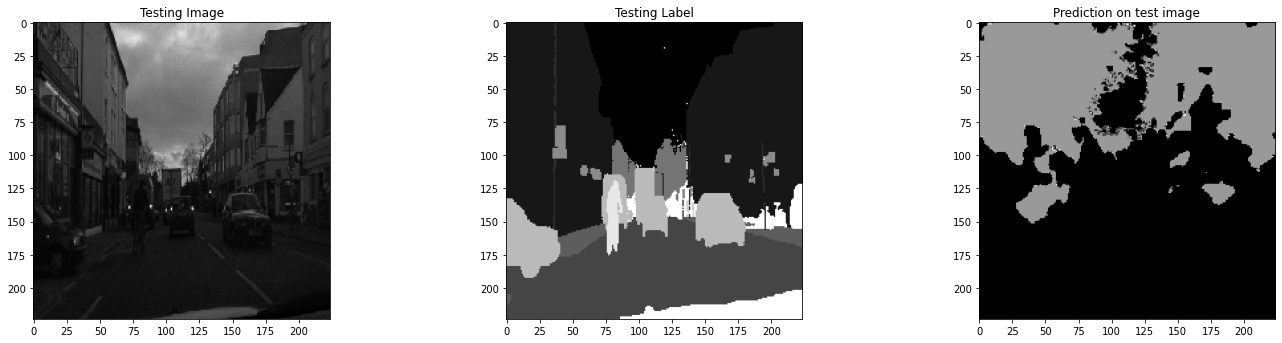

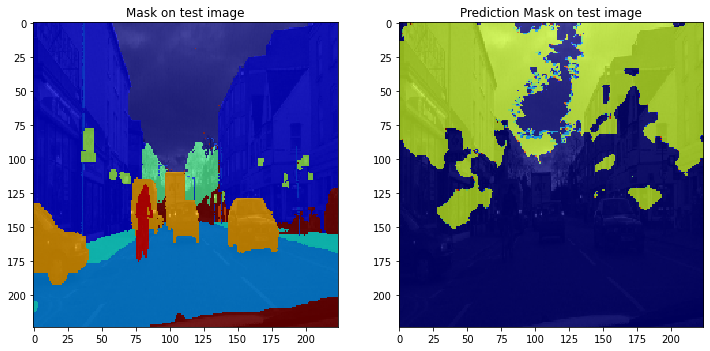

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Linknet_Mobilenetv2 Training and validation Jloss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Linknet_Mobilenetv2 Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

iou_scoreall = history.history['iou_score']
val_iou_scoreall = history.history['val_iou_score']

plt.plot(epochs, iou_scoreall, 'y', label='Training iou_score all')
plt.plot(epochs, val_iou_scoreall, 'r', label='Validation iou_score all')
plt.title('Linknet_Mobilenetv2 Training and validation iou_score all')
plt.xlabel('Epochs')
plt.ylabel('iou_score_all')
plt.legend()
plt.show()
loss = history.history['kullback_leibler_divergence']
val_loss = history.history['val_kullback_leibler_divergence']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training kullback_leibler_divergence')
plt.plot(epochs, val_loss, 'r', label='Validation kullback_leibler_divergence')
plt.title('Mobilenet_Unet Training and validation kullback_leibler_divergence')
plt.xlabel('Epochs')
plt.ylabel('kullback_leibler_divergence')
plt.legend()
plt.show()

acc = history.history['poisson']
val_acc = history.history['val_poisson']

plt.plot(epochs, acc, 'y', label='Training poisson')
plt.plot(epochs, val_acc, 'r', label='Validation poisson')
plt.title('Mobilenet_Unet Training and validation poisson')
plt.xlabel('Epochs')
plt.ylabel('poisson')
plt.legend()
plt.show()

#IOU
y_pred=model.predict(X_val)
y_pred_thresholded = y_pred > 0.5
print("validation accuracy",y_pred[1].shape)



intersection = np.logical_and(y_val, y_pred_thresholded)
union = np.logical_or(y_val, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)


test_img = X_val[2]
ground_truth=y_val[2]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(X_val))

mask = np.argmax(prediction[2], axis=-1)
print(mask.shape)
mask = np.expand_dims(mask, axis=-1)
print(mask.shape)
img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
print(mask.shape)

plt.figure(figsize=(24, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(img, cmap='gray')

plt.show()
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.imshow(test_img[:,:,0], 'gray', interpolation='none')
plt.imshow(ground_truth[:,:,0], 'jet', interpolation='none', alpha=0.7)
plt.title('Mask on test image')
plt.subplot(1,2,2)
plt.imshow(test_img[:,:,0], 'gray', interpolation='none')
plt.imshow(img, 'jet', interpolation='none', alpha=0.7)
plt.title('Prediction Mask on test image')
plt.show()

Not Functional

In [ ]:
BACKBONE = 'efficientnetb7'
preprocess_input = sm.get_preprocessing(BACKBONE)
keras.backend.set_image_data_format('channels_last')
# define model
model = sm.Linknet(BACKBONE, input_shape=(224, 224, 3), encoder_weights='imagenet', classes=11, activation='sigmoid')
model.summary()
#plot_model(model, to_file='/content/drive/MyDrive/Colab Notebooks/A3_Dataset/Linknet_efficientnetb7_segmentation.png')

258434480/258434480 [==============================] - 10s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 64  1728        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 64  256         ['stem_conv[0][0]']              
                        

EfficentUnet no transfer learning

In [ ]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
   

    
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)#(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    
    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes,2, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

keras.backend.clear_session()
img_size=(224,224)
num_classes=12
# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
from segmentation_models.metrics import iou_score

model.compile(optimizer="Adam", loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score, 'Accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/dataset1/City_segmentation11.h5", save_best_only=True)
]

batch_size = 32
steps_per_epoch = (3)*(len(X_train))//batch_size


# Train the model, doing validation at the end of each epoch.
epochs = 25
history=model.fit(my_generator, epochs=epochs, validation_data=validation_datagen,steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, callbacks=callbacks)

Epoch 1/25
27/27 [==============================] - 32s 990ms/step - loss: -13041.6982 - iou_score: 3.0262 - Accuracy: 0.7901 - val_loss: -25685.4473 - val_iou_score: 4.1536 - val_Accuracy: 1.0000
Epoch 2/25
27/27 [==============================] - 27s 1s/step - loss: -5522912.5000 - iou_score: 3.1859 - Accuracy: 0.9993 - val_loss: -8339408.5000 - val_iou_score: 4.1090 - val_Accuracy: 1.0000
Epoch 3/25
27/27 [==============================] - 25s 959ms/step - loss: -424365280.0000 - iou_score: 3.0404 - Accuracy: 0.9999 - val_loss: -559858816.0000 - val_iou_score: 4.0496 - val_Accuracy: 1.0000
Epoch 4/25
27/27 [==============================] - 26s 970ms/step - loss: -12427064320.0000 - iou_score: 3.0669 - Accuracy: 0.9999 - val_loss: -15269946368.0000 - val_iou_score: 4.0955 - val_Accuracy: 1.0000
Epoch 5/25
27/27 [==============================] - 25s 950ms/step - loss: -196067393536.0000 - iou_score: 3.1944 - Accuracy: 0.9999 - val_loss: -289525596160.0000 - val_iou_score: 4.0920 - v

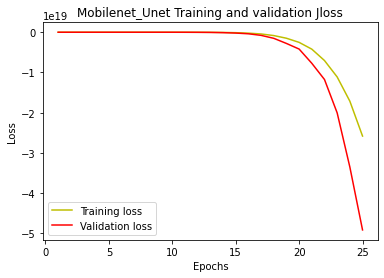

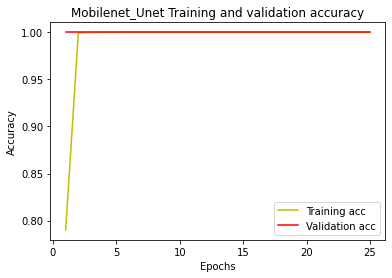

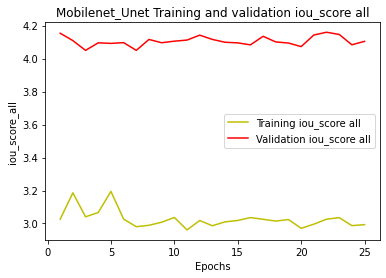

3/3 [==============================] - 0s 111ms/step
IoU socre is:  0.8400417018581081
3/3 [==============================] - 0s 87ms/step


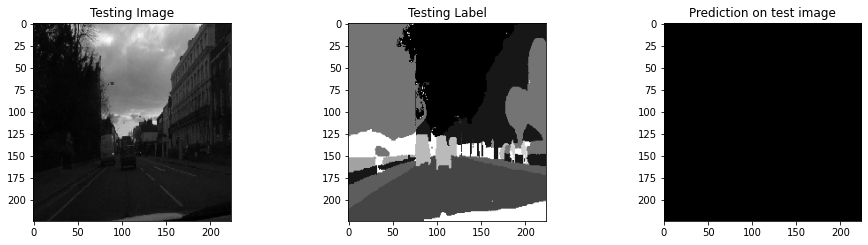

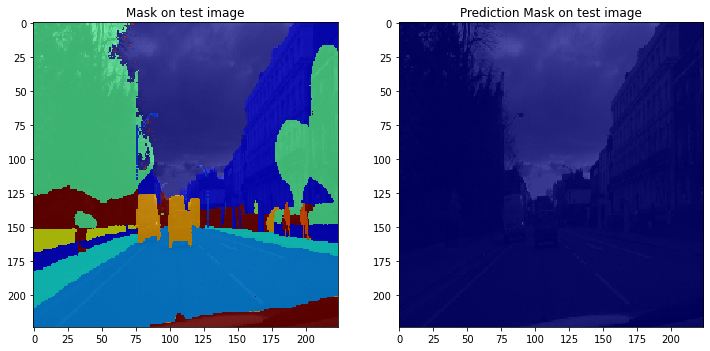

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Mobilenet_Unet Training and validation Jloss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Mobilenet_Unet Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

iou_scoreall = history.history['iou_score']
val_iou_scoreall = history.history['val_iou_score']

plt.plot(epochs, iou_scoreall, 'y', label='Training iou_score all')
plt.plot(epochs, val_iou_scoreall, 'r', label='Validation iou_score all')
plt.title('Mobilenet_Unet Training and validation iou_score all')
plt.xlabel('Epochs')
plt.ylabel('iou_score_all')
plt.legend()
plt.show()

#IOU
y_pred=model.predict(X_val)
y_pred_thresholded = y_pred > 0.5
#print("validation accuracy",y_pred[1])

intersection = np.logical_and(y_val, y_pred_thresholded)
union = np.logical_or(y_val, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

#Predict on a few images
#model = get_model()
#model.load_weights('mitochondria_50_plus_100_epochs.hdf5') #Trained for 50 epochs and then additional 100

#test_img_number = random.randint(0, len(X_val))
test_img = X_val[3]
ground_truth=y_val[3]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(X_val))

mask = np.argmax(prediction[3], axis=-1)
mask = np.expand_dims(mask, axis=-1)
img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))



plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(img, cmap='gray')

plt.show()
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.imshow(test_img[:,:,0], 'gray', interpolation='none')
plt.imshow(ground_truth[:,:,0], 'jet', interpolation='none', alpha=0.7)
plt.title('Mask on test image')
plt.subplot(1,2,2)
plt.imshow(test_img[:,:,0], 'gray', interpolation='none')
plt.imshow(img, 'jet', interpolation='none', alpha=0.7)
plt.title('Prediction Mask on test image')
plt.show()